# Алексей Сек, БЭК182

### Источники:
Конечно, много информации о работе LSTM, прогнозировании временных рядов до этого я не знал, поэтому ознакомился с различными открытыми статьями и документацией tensorflow)
1. https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
2. https://habr.com/en/post/495884/
3. https://habr.com/ru/post/327022/
4. http://stackoverflow.com/users/190280/josh-bleecher-snyder - Courtsey 
5. https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651
6. https://finance.yahoo.com/quote/GOOG/history?period1=1433203200&period2=1591056000&interval=1d&filter=history&frequency=1d
7. https://www.tensorflow.org/api_docs/python/tf/keras/

В коде я постарался максимально понятно и подробно описать, что и зачем выполняется

In [30]:
# Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time
import matplotlib.ticker as tkr

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import pacf
import math

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

Для меня было интересно прогнозирование временных рядов: задача не совсем заурядная - чтобы делать прогнозы по предыдущим дням - нам необходимо создать окно из этих предыдущих дней (возьмем 30), а прогнозировать будем 30+1 день

Очень много времени ушло на понимание того, как именно должны быть устроены данные для обучения и для тестирования для того, чтобы tensorflow можно было применить

Я скачал датасет с yahoo finance по акциям Alphbet (Google) - они в открытом доступе в формате csv

In [31]:
# Считаем данные - у нас массив данных по акциям Alphbet (google) с сайта yahoo finannce за последние 5 лет
data = pd.read_csv('/Users/Alexey/Desktop/GOOG.csv')[::-1]

# Даты были в обратном порядке, поэтому отсортируем их
data.sort_index(inplace=True)

In [32]:
# Посмотрим на наши данные
print(data.shape)
print(data.head())

# У нас 1259 наблюдений (дней, за которые есть данные за последние 5 лет)

(1259, 7)
         Date     Open     High      Low    Close  Adj Close   Volume
0  2015-06-02 532.9300 543.0000 531.3300 539.1800   539.1800  1939000
1  2015-06-03 539.9100 543.5000 537.1100 540.3100   540.3100  1717000
2  2015-06-04 537.7600 540.5900 534.3200 536.7000   536.7000  1348300
3  2015-06-05 536.3500 537.2000 532.5200 533.3300   533.3300  1388200
4  2015-06-08 533.3100 534.1200 526.2400 526.8300   526.8300  1520600


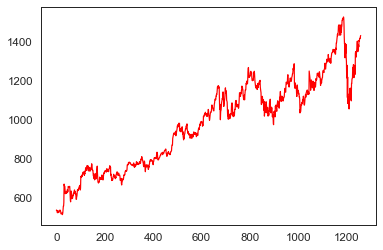

In [33]:
# Нам важна цена закрытия, посмотрим на ее динамику за последние 5 лет:
plt.plot(data.Close, color='r')

In [34]:
# Функцию позаимствовал:
# https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

# На самом деле суть простая - нарезаем с шагом 1 данные по 30 дней для X (данные, на которых мы предсказываем)
# и 30+1 день для Y (то, что именно мы предсказываем)
# Получаем много "окон" из 30 дней и 1 дня после, на которых будем тренировать сеть
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [35]:
# У нас 7 столбцов, но прогнозировать мы будем только цену закрытия
dataset = np.array(data.Close)

# Чтобы прогнозировать непрерывные случайные величины, формат чисел должен быть float, а не int
dataset = dataset.astype('float32')

# Изменим размерность матрицы
dataset = np.reshape(dataset, (-1, 1))

# Приведем все значения в диапазон от 0 до 1 (стандартиизация)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Определим размеры тренировочной и тестовой выборки
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size

# Разрежем данные на тренировочную и тестовую выборки
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [36]:
# Количество дней, на основе которых мы делаем прогноз (размер окна)
look_back = 30

# Используем написанную ранее функцию для создания данных для обучения нейронной сети
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Для tensorflow нужна следующая размерность [количество выборок, количество дней в окне, количество признаков]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Исходя из источников, которые я прочитал, для такого типа прогнозов (прогноз следующей даты по имеющимся данным за предыдущие дни) один из лучших вариантов - LSTM архитектура рекуррентной нейронной сети

Ее я и выбрал для решения задачи

In [37]:
# Построим необходимую модель нейросети: будем использовать LSTM

# Предсказываем временные ряды
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))

# Нужно для исключения переобучения: "выбрасываем" на некоторых итерациях случайные нейроны
model.add(Dropout(0.2))

# На выходе должен быть прогноз по 1 дню
model.add(Dense(1))

# Функция ошибок mse, оптимизатор ADAM
# Более подробно об ADAM: https://habr.com/en/post/318970/
model.compile(loss='mean_squared_error', optimizer='adam')

# Начнем процесс тренировки модели:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 976 samples, validate on 221 samples
Epoch 1/20
976/976 [==============================] - 2s 2ms/sample - loss: 0.0258 - val_loss: 0.0269
Epoch 2/20
976/976 [==============================] - 0s 101us/sample - loss: 0.0041 - val_loss: 0.0118
Epoch 3/20
976/976 [==============================] - 0s 86us/sample - loss: 0.0036 - val_loss: 0.0065
Epoch 4/20
976/976 [==============================] - 0s 81us/sample - loss: 0.0041 - val_loss: 0.0105
Epoch 5/20
976/976 [==============================] - 0s 86us/sample - loss: 0.0039 - val_loss: 0.0064
Epoch 6/20
976/976 [==============================] - 0s 83us/sample - loss: 0.0046 - val_loss: 0.0120
Epoch 7/20
976/976 [==============================] - 0s 90us/sample - loss: 0.0046 - val_loss: 0.0067
Epoch 8/20
976/976 [==============================] - 0s 94us/sample - loss: 0.0046 - val_loss: 0.0124
Epoch 9/20
976/976 [==============================] - 0s 94us/sample - loss: 0.0042 - val_loss: 0.0066
Epoch 10/20
976/976 [======

In [38]:
# Сделаем прогноз
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [39]:
# Мы до этого сжали данные в отрезок от 0 до 1, теперь вернем их в исходное состояние
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [40]:
# Выведем ошибки модели
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 24.910023515313704
Train Root Mean Squared Error: 31.877960388477575
Test Mean Absolute Error: 61.684662717516176
Test Root Mean Squared Error: 74.60548433750142


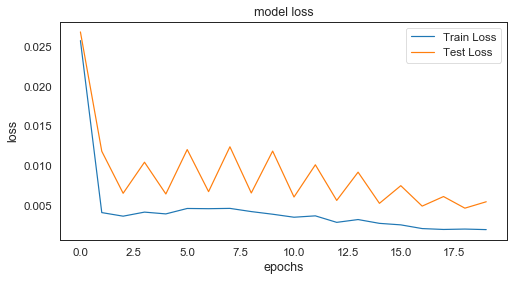

In [41]:
# Выведем функцию ошибок от количества итераций обучения модели
# Видно, что после 10 улучшение прогноза с каждой итерацией обучения снижается

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

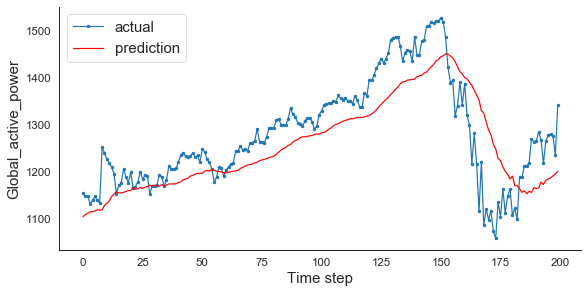

In [42]:
# Посмотрим на 200 выборок из тестовых данных
aa=[x for x in range(200)]

# Построим график и посмотрим, насколько хорошо сеть предсказывает тестовую выборку
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Как видим, LSTM отлично справилась с поставленной задачей